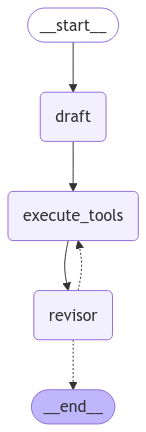

In [5]:
from langgraph.graph import StateGraph, START, END
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from utilities import extract_last_tool_criteria, generate_human_message
from langchain_core.tools import StructuredTool
from tools import available_food_search
from langgraph.prebuilt import ToolNode

from agents.reflextions_agents import (
    food_suggestion_runnable,
    food_revision_runnable,
    ReviseFoodRecommendation, FoodRecommendation)
from utilities import Assistant, State
from langgraph.prebuilt import tools_condition

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)






def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=FoodRecommendation.__name__),
        StructuredTool.from_function(run_queries, name=ReviseFoodRecommendation.__name__),
        available_food_search
    ]
)





def route_food_suggestion(
    state: State,
):
    route = tools_condition(state)
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == FoodRecommendation.__name__:
            return END
    return route

def draft_node(state:State):
    first_responder = Assistant(food_suggestion_runnable)
    user_intent = extract_last_tool_criteria(state)
    return {"messages":first_responder.respond(
    {"messages": [generate_human_message(user_intent)]})}

def revisor_node(state:State):
    user_intent = extract_last_tool_criteria(state)
    revisor = Assistant(food_revision_runnable)

    return {"messages":revisor.respond(
    {
        "messages": [
            generate_human_message(user_intent),
            state["messages"][-2],
            # ToolMessage(
            #     tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            #     content=json.dumps(
            #         tavily_tool.invoke(
            #             {
            #                 "query": state["messages"][-1].tool_calls[0]["args"][
            #                     "search_queries"
            #                 ][0]
            #             }
            #         )
            #     ),
            # ),
        ]
    }
)}


builder = StateGraph(State)
builder.add_node("draft", draft_node)
builder.add_node("revisor", revisor_node)
builder.add_node("execute_tools", tool_node)
builder.add_edge("__start__", "draft")

builder.add_edge("draft", "execute_tools")

builder.add_edge("execute_tools", "revisor")
builder.add_conditional_edges("revisor", route_food_suggestion, [END, "execute_tools"])
builder.add_edge(START, "draft")

part_5_graph = builder.compile()

from IPython.display import Image, display

try:
    display(Image(part_5_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(e)
    # This requires some extra dependencies and is optional
    pass
